In [1]:
"""
GP emulation
"""
##### Packages ###############
import numpy as np  
import matplotlib.pylab as plt
import time
import pickle
import os
from sklearn.decomposition import PCA
# import GPy
import matplotlib.ticker as ticker
import gpflow


In [2]:
############################# PARAMETERS ##############################

dataDir = "./Data/Fixedn/" ## Data folder
modelDir = "./Models/Fixedn/" ## Data folder
plotsDir = "./Plots/Fixedn/" ## Data folder

nRankMax = [2, 4, 8, 12, 16, 32][4]  ## Number of basis vectors in truncated PCA
## Increasing nRankMax will increase emulation precision (asymptotically), but reduce the speed

# del_idx = [5, 25, 4, 42]  ## Random holdouts (not used in training, reserved for validation) 
# del_idx = [4]  ## Random holdouts (not used in training, reserved for validation) 
# del_idx = [11, 17, 20, 37, 46]  ## Random holdouts (not used in training, reserved for validation) 
del_idx = [11, 5, 4, 42]  ## Random holdouts (not used in training, reserved for validation) 
# del_idx = []  ## Random holdouts (not used in training, reserved for validation) 

# 11, 17, 20, 37, 46, 
# DONOT use these: (array([22, 15, 19, 20, 35]), array([27, 34, 30, 29, 14])) -- edge cases
snap_ID = 79


############################# PARAMETERS ##############################


fileIn = dataDir + 'ratiosbinsnew_' + str(snap_ID) + '.txt'
paramIn = dataDir + 'mg_log.design'



# paramIn = dataDir + 'mg.design'
# fileIn = dataDir + ['ratios.txt', 'PMG.txt'][0]



# plotsDir = "./Plots/" ## Data folder
# dataDir = "./Data/Emulator_data/" ## Data folder
# dataDir = "./Data/Emulator213bins/" ## Data folder

# paramIn = dataDir + 'mg.design'  ## parameter file



az = np.loadtxt(dataDir + 'timestepsCOLA.txt', skiprows=1) 
fileIn = dataDir + 'ratiosbinsnew_' + str(snap_ID) + '.txt'

### GPmodel = modelDir + 'a89003GPflow_model_213Smooth_rank' + str(nRankMax) + 'snap' + str(snap_ID)  ## Double and single quotes are necessary
# GPmodel = modelDir + 'a89004GPflow_model_213Smooth_rank' + str(nRankMax) + 'snap' + str(snap_ID)  ## Double and single quotes are necessary
GPmodel = modelDir + 'nCorrLogfixedGP_smooth_rank' + str(nRankMax) + 'snap' + str(snap_ID)  ## Double and single quotes are necessary
PCAmodel = modelDir + 'nCorrLogfixedPCA_smooth_rank' + str(nRankMax) + 'snap' + str(snap_ID)  ## Double and single quotes are necessary

print(GPmodel)
################################# I/O #################################


./Models/Fixedn/nCorrLogfixedGP_smooth_rank16snap79


In [3]:
loadFile = np.loadtxt(fileIn)
PmPl_all = loadFile[:, 1:].T
kvals = loadFile[:,0]

parameter_array_all = np.loadtxt(paramIn)

In [4]:
# plt.figure(23)
# plt.hist(np.log10(parameter_array_all[:, 3]))
# plt.show()

In [5]:
parameter_array_all[:, 3] = np.log10(parameter_array_all[:, 3])

In [6]:



# ############## rescaling ##############


# def rescale01(f):
#     return np.min(f), np.max(f), (f - np.min(f)) / (np.max(f) - np.min(f))


# lhd = np.zeros_like(parameter_array_all)
# for i in range(parameter_array_all.shape[1]):
#     _, _, lhd[:, i] = rescale01(parameter_array_all[:, i])
   

# parameter_array_all = lhd

# # _,_,PmPl_all = rescale01(loadFile[:, 1:].T)









############## rescaling ##############


def rescale01(f):
    return np.min(f), np.max(f), (f - np.min(f)) / (np.max(f) - np.min(f))


def scale01(fmin, fmax, f):
    return (f - fmin) / (fmax - fmin)
#     return f*(fmax - fmin) + fmin


lhd = np.zeros_like(parameter_array_all)
lhdmin = np.zeros_like(parameter_array_all[1])
lhdmax = np.zeros_like(parameter_array_all[1])

for i in range(parameter_array_all.shape[1]):
    lhdmin[i], lhdmax[i], lhd[:, i] = rescale01(parameter_array_all[:, i])
   

parameter_array_all = lhd
np.savetxt(dataDir+'paralims_nCorr.txt', np.array([lhdmin, lhdmax]))


############## rescaling ##############


## Removing hold-out test points
parameter_array = np.delete(parameter_array_all, del_idx, axis=0)
PmPl = np.delete(PmPl_all, del_idx, axis=0)



In [7]:
# orig_param = np.loadtxt(paramIn)
# print(np.argmin(orig_param, axis=0), np.argmax(orig_param, axis=0))
# print(np.where(orig_param[:,3] == orig_param[:,3].min()))
# print(np.where(orig_param[:, 3] < 1e-5))

In [8]:
# np.min(np.loadtxt(paramIn), axis=0)

In [9]:
# np.max(np.loadtxt(paramIn), axis=0)

In [10]:
# np.savetxt(dataDir+'kvals.txt', kvals)

In [11]:
lhdmin, lhdmax = np.loadtxt(dataDir + 'paralims_nCorr.txt')

In [12]:
#### adding smoothing filter ########

import scipy.signal
yhat = scipy.signal.savgol_filter(PmPl[:,:], 51, 3) # window size 51, polynomial order 3
y_train = yhat

####################################

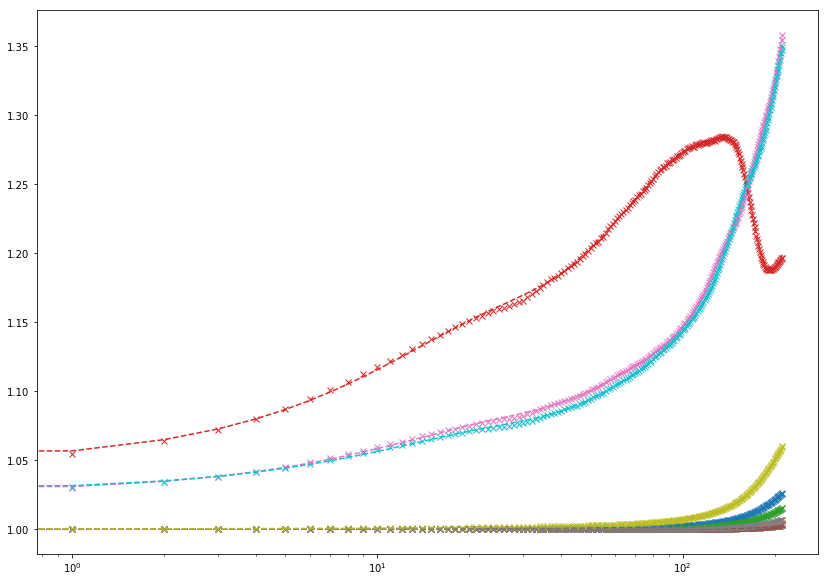

In [13]:
import scipy.signal

yhat = scipy.signal.savgol_filter(y_train, 51, 3) # window size 51, polynomial order 3


plt.figure(121, (14,10))
plt.plot( np.array(y_train).T[:,0:10], 'x')
plt.plot( np.array(yhat).T[:,0:10], '--')
plt.xscale('log')

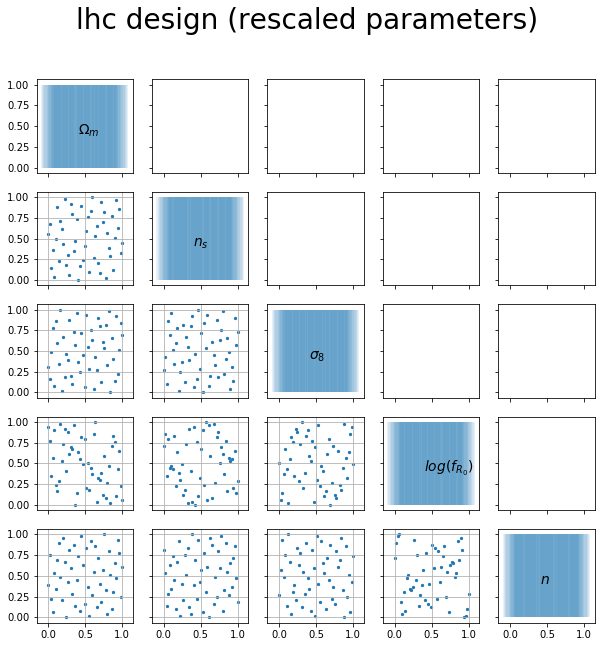

In [14]:
############################# Plot the input parameter distribution ##############################

allLabels = [r'${\Omega}_m$', r'$n_s$', r'${\sigma}_8$', r'$log(f_{R_0})$', r'$n$']


lhd = np.zeros_like(parameter_array_all)
for i in range(parameter_array_all.shape[1]):
    _,_,lhd[:, i] = rescale01(parameter_array_all[:, i])
    
def plot_params(lhd):
    f, a = plt.subplots(lhd.shape[1], lhd.shape[1], sharex=True, sharey=True, figsize=(10, 10) )
    plt.suptitle('lhc design (rescaled parameters)', fontsize = 28)
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
    plt.rcParams.update({'font.size': 8})

    for i in range(lhd.shape[1]):
        for j in range(i + 1):
            # print(i, j)
            if (i != j):
                a[i, j].scatter(lhd[:, i], lhd[:, j], s=5)
                a[i, j].grid(True)
            else:
                hist, bin_edges = np.histogram(lhd[:, i], density=True, bins=64)
                a[i, i].text(0.4, 0.4, allLabels[i], size = 'xx-large')

                a[i, i].bar(bin_edges[:-1], hist / hist.max(), width=0.2, alpha = 0.1)


    plt.show()


plot_params(lhd)

In [15]:
########################### PCA ###################################
# set up pca compression
from sklearn.decomposition import PCA


def PCA_compress(x, nComp):
    # x is in shape (nparams, nbins)
    pca_model = PCA(n_components=nComp)
    principalComponents = pca_model.fit_transform(x)
    pca_bases = pca_model.components_

    print("original shape:   ", x.shape)
    print("transformed shape:", principalComponents.shape)
    print("bases shape:", pca_bases.shape)

    import pickle
    pickle.dump(pca_model, open(PCAmodel, 'wb'))

    return pca_model, np.array(principalComponents), np.array(pca_bases)


######################## GP FITTING ################################

## Build GP models
# This is evaluated only once for the file name. GP fitting is not required if the file exists.
  

def GPflow_fit(parameter_array, weights, fname= GPmodel):
    # kern = gpflow.kernels.Matern52(input_dim = np.shape(parameter_array)[1], ARD=True)
    # kern = gpflow.kernels.Matern12(input_dim = np.shape(parameter_array)[1], ARD=False)
    # kern = gpflow.kernels.Matern32(input_dim = np.shape(parameter_array)[1], ARD=True)
    # kern = gpflow.kernels.RBF(input_dim = np.shape(parameter_array)[1], ARD=True)

    kern1 = gpflow.kernels.RBF(input_dim = np.shape(parameter_array)[1], ARD=True)
    kern2 = gpflow.kernels.RBF(input_dim = np.shape(parameter_array)[1], ARD=False)

    kern = kern1 + kern2


#     m1 = GPy.models.GPRegression(parameter_array, weights, kernel=kern)
    m = gpflow.models.GPR(parameter_array, weights, kern=kern, mean_function=None)
#     print_summary(m)
    # m.likelihood.variance.assign(0.01)
    # m.likelihood.variance.assign(1.0)
    # m.likelihood.variance.assign(5.0)

##     m.kern.lengthscales.assign([0.3, 0.1, 0.2, 0.3, 0.1])
    # m.kern.lengthscales.assign([25, 65, 15 ,1, 1])
    # m.kern.lengthscales.assign(0.5)
    
    opt = gpflow.train.ScipyOptimizer()
    opt.minimize(m)
    m.as_pandas_table()
    
    from pathlib import Path

    # print(f'GPR lengthscales =', m.kern.lengthscales.value)

    
    path = Path(GPmodel)
    if path.exists():
        path.unlink()
    
    saver = gpflow.saver.Saver()
    saver.save(fname, m)
    



In [16]:
######################## GP PREDICTION FUNCTIONS ###############################


def GPy_predict(para_array):
    m1p = m1.predict_f(para_array)  # [0] is the mean and [1] the predictive
    W_predArray = m1p[0]
    W_varArray = m1p[1]
    return W_predArray, W_varArray


def Emu(para_array):
    if len(para_array.shape) == 1:
        W_predArray, _ = GPy_predict(np.expand_dims(para_array, axis=0))
        x_decoded = pca_model.inverse_transform(W_predArray)
        return np.squeeze(x_decoded)#[0]

def EmuPlusMinus(para_array):
    if len(para_array.shape) == 1:
        W_predArray, W_varArray = GPy_predict(np.expand_dims(para_array, axis=0))
        x_decoded = pca_model.inverse_transform(W_predArray)
        x_decoded_plus = pca_model.inverse_transform(W_predArray + np.sqrt(W_varArray))
        x_decoded_minus = pca_model.inverse_transform(W_predArray - np.sqrt(W_varArray))
        return np.squeeze(x_decoded), np.squeeze(x_decoded_plus), np.squeeze(x_decoded_minus)


In [17]:
# pca_model, pca_weights, pca_bases = PCA_compress(PmPl, nComp=nRankMax)
pca_model, pca_weights, pca_bases = PCA_compress(y_train, nComp=nRankMax)

print('----------------')
print(parameter_array.shape)
print(pca_weights.shape)
print('----------------')

GPflow_fit(parameter_array, pca_weights)

original shape:    (46, 213)
transformed shape: (46, 16)
bases shape: (16, 213)
----------------
(46, 5)
(46, 16)
----------------






INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -1104.214959
  Number of iterations: 53
  Number of functions evaluations: 66
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -1104.214959
  Number of iterations: 53
  Number of functions evaluations: 66


In [18]:
PmPl_all.max(), PmPl_all.min()

(1.58694982, 0.99956107)

In [19]:
GPmodel

'./Models/Fixedn/nCorrLogfixedGP_smooth_rank16snap79'

[0.14, 1.0, 0.7, 1e-05, 1.0]
[0.57142857 0.75       0.         2.0000025  0.25      ]
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().
Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().


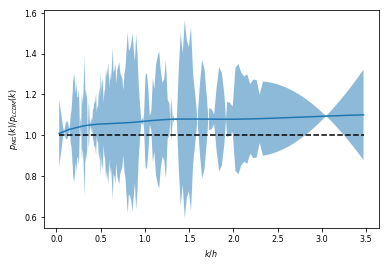

In [20]:
# par = [0.136512329, 0.971, 0.82, 1e-06, 1]
# 11, 17, 20, 37, 46
# params = np.loadtxt(paramIn)

ctx_for_loading = gpflow.saver.SaverContext(autocompile=False)
saver = gpflow.saver.Saver()

m1 = saver.load(GPmodel, context=ctx_for_loading)
m1.clear()
m1.compile()

pca_model = pickle.load(open(PCAmodel, 'rb'))



params = np.loadtxt(paramIn)
params.min()
par = params[46]
# par = [1.46428570e-01, 9.56122398e-01, 8.14285755e-01, 2.05061588e-06, 8.16328004e-02] #params[11]
par = [0.14, 1.0, 0.7, 1e-5, 1.0] #params[11]

scaled_par = scale01(lhdmin, lhdmax, par)
print(par)
print( (scaled_par))

# x_id = 46
# 
# 

# print( params[np.argmin(params[:,3])])
# print(parameter_array_all[x_id])
plt.figure(12)
Emu(scaled_par)
# plt.plot(kvals, Emu(scaled_par))
plt.plot(kvals, EmuPlusMinus(scaled_par)[0])
plt.fill_between(kvals, EmuPlusMinus(scaled_par)[1], EmuPlusMinus(scaled_par)[2], alpha = 0.5)
plt.plot(kvals, np.ones_like(kvals), 'k--')

plt.ylabel(r'$p_{MG}(k)/p_{LCDM}(k)$')
plt.xlabel(r'$k/h$')

plt.show()

In [21]:
# def EmuM(gpmodel, pcamodel, para_array):
#     para_array = np.array(para_array)
#     # print(para_array)
#     para_array_rescaled = scale01(lhdmin, lhdmax, para_array)
#     if len(para_array.shape) == 1:
#         # print(para_array_rescaled)
#         W_predArray, _ = GPy_predict(gpmodel, np.expand_dims(para_array_rescaled, axis=0))
#         x_decoded = pcamodel.inverse_transform(W_predArray)
#         return np.squeeze(x_decoded)#[0]


# def GPy_predict(para_array):
#     m1p = m1.predict_f(para_array)  # [0] is the mean and [1] the predictive
#     W_predArray = m1p[0]
#     W_varArray = m1p[1]
#     return W_predArray, W_varArray


# def Emu(para_array):
#     if len(para_array.shape) == 1:
#         W_predArray, _ = GPy_predict(np.expand_dims(para_array, axis=0))
#         x_decoded = pca_model.inverse_transform(W_predArray)
#         return np.squeeze(x_decoded)#[0]


In [22]:
# m1 = GPmodel
# Emu(np.array(scaled_par))
# EmuM(m1, pca_model, np.array(par))

Time per emulation 1.17138  s
Time per emulation 0.00783  s
Time per emulation 0.01076  s
Time per emulation 0.00603  s


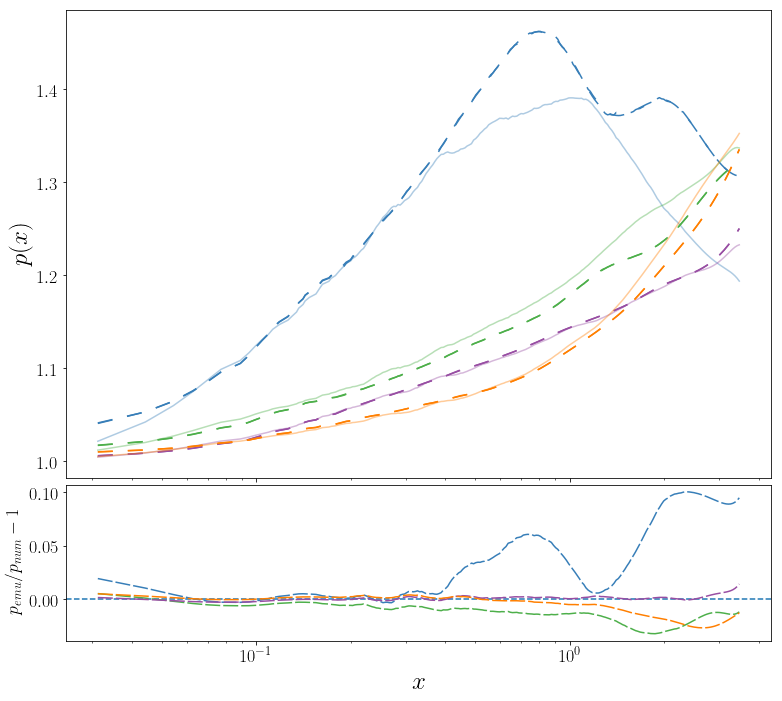

In [23]:
#### GP POSTERIOR DRAWS and PCA RECONSTRUCTIONS ######

# m1 = GPy.models.GPRegression.load_model(modelDir + 'GPy_model_rank' +str(nRankMax)+ '.zip')
# pca_model = pickle.load(open(modelDir + 'PCA_model_rank'+str(nRankMax), 'rb'))

# m1 = GPy.models.GPRegression.load_model(modelDir + 'GPy_model'+ str(nRankMax) +'.zip')
# m1 = GPy.models.GPRegression.load_model(GPmodel + '.zip')

ctx_for_loading = gpflow.saver.SaverContext(autocompile=False)
saver = gpflow.saver.Saver()

m1 = saver.load(GPmodel, context=ctx_for_loading)
m1.clear()
m1.compile()

pca_model = pickle.load(open(PCAmodel, 'rb'))

plt.rc('text', usetex=True)  # Slower
plt.rc('font', size=18)  # 18 usually

plt.figure(999, figsize=(14, 12))
from matplotlib import gridspec

gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
gs.update(hspace=0.02, left=0.2, bottom=0.15)
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])

ax0.set_ylabel(r'$p(x)$', fontsize=25)
ax1.set_xlabel(r'$x$', fontsize=25)
ax1.set_ylabel(r'$p_{emu}/p_{num} - 1$', fontsize = 18)
# ax1.set_ylim(-5e-2, 5e-2)

ax0.set_xscale('log')
# ax0.set_yscale('log')
ax1.set_xscale('log')

ax1.axhline(y=0, ls='dashed')

color_id = 0
# del_idx = [4]
for x_id in del_idx:
    color_id = color_id + 1
    time0 = time.time()
#     x_decoded_new = Emu(parameter_array_all[x_id], PCAmodel='PCA_model', GPmodel='GPy_model')
    x_decoded_new = Emu(parameter_array_all[x_id])
    x_decoded_smooth = scipy.signal.savgol_filter(x_decoded_new , 51, 6)
    
    # ax0.plot(kvals, EmuPlusMinus(parameter_array_all[x_id])[0])
    # ax0.fill_between(kvals, EmuPlusMinus(parameter_array_all[x_id])[1], EmuPlusMinus(parameter_array_all[x_id])[2], alpha = 0.5)

    time1 = time.time()
    print('Time per emulation %0.5f' % (time1 - time0), ' s')
    ax0.plot(kvals, x_decoded_new, alpha=1.0, lw = 1.5, ls='--', label='emu', dashes=(10, 10), color=plt.cm.Set1(color_id))
    ax0.plot(kvals, x_decoded_smooth, alpha=1.0, lw = 1.5, ls='--', label='emu', dashes=(10, 10), color=plt.cm.Set1(color_id))

#     x_test = PmPl_all[x_id]
    x_test = scipy.signal.savgol_filter(PmPl_all[x_id], 51, 6)

    ax0.plot(kvals, x_test, alpha=0.4, label='real', color=plt.cm.Set1(color_id))

    ax1.plot(kvals, (x_decoded_smooth / (x_test) ) - 1, ls='--', dashes=(10, 2), color=plt.cm.Set1(color_id))


ax0.set_xticklabels([])
plt.savefig(plotsDir + 'Pemu_rank' +str(nRankMax) + '.png', figsize=(28, 24), bbox_inches="tight")
plt.show()

Time per emulation 1.42446  s
Time per emulation 0.03212  s
Time per emulation 0.03482  s
Time per emulation 0.03342  s


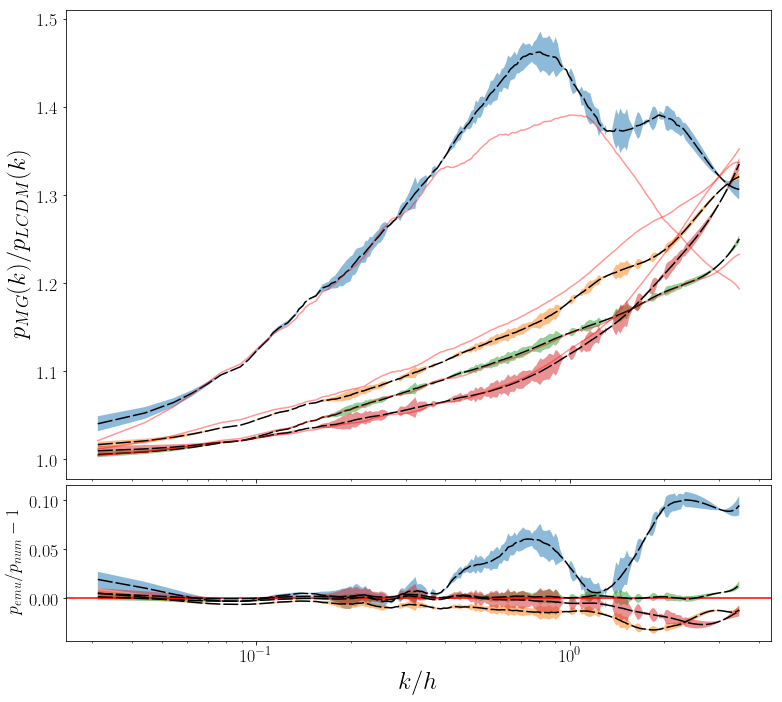

In [24]:
#### GP POSTERIOR DRAWS and PCA RECONSTRUCTIONS ######

# m1 = GPy.models.GPRegression.load_model(modelDir + 'GPy_model_rank' +str(nRankMax)+ '.zip')
# pca_model = pickle.load(open(modelDir + 'PCA_model_rank'+str(nRankMax), 'rb'))

# m1 = GPy.models.GPRegression.load_model(modelDir + 'GPy_model'+ str(nRankMax) +'.zip')
# m1 = GPy.models.GPRegression.load_model(GPmodel + '.zip')

ctx_for_loading = gpflow.saver.SaverContext(autocompile=False)
saver = gpflow.saver.Saver()

m1 = saver.load(GPmodel, context=ctx_for_loading)
m1.clear()
m1.compile()

pca_model = pickle.load(open(PCAmodel, 'rb'))

plt.rc('text', usetex=True)  # Slower
plt.rc('font', size=18)  # 18 usually

plt.figure(999, figsize=(14, 12))
from matplotlib import gridspec

gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
gs.update(hspace=0.02, left=0.2, bottom=0.15)
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])

ax0.set_ylabel(r'$p(x)$', fontsize=25)
ax1.set_xlabel(r'$x$', fontsize=25)
ax1.set_ylabel(r'$p_{emu}/p_{num} - 1$', fontsize = 18)
# ax1.set_ylim(-5e-2, 5e-2)

ax0.set_xscale('log')
# ax0.set_yscale('log')
ax1.set_xscale('log')

ax1.axhline(y=0, color = 'r')

color_id = 0
# del_idx = [4]
for x_id in del_idx:
    color_id = color_id + 1
    time0 = time.time()
    x_decoded_new = Emu(parameter_array_all[x_id])
    x_decoded_smooth = scipy.signal.savgol_filter(x_decoded_new , 51, 6)
    
    ax0.plot(kvals, EmuPlusMinus(parameter_array_all[x_id])[0], ls='--', dashes=(10, 2), color='k')
    ax0.fill_between(kvals, EmuPlusMinus(parameter_array_all[x_id])[1], EmuPlusMinus(parameter_array_all[x_id])[2], alpha = 0.5)

    time1 = time.time()
    print('Time per emulation %0.5f' % (time1 - time0), ' s')
    # ax0.plot(kvals, x_decoded_new, alpha=1.0, lw = 1.5, ls='--', color = 'k', label='emu', dashes=(10, 10))
    # ax0.plot(kvals, x_decoded_smooth, alpha=1.0, lw = 1.5, ls='--', color = 'r', label='emu', dashes=(10, 10))

#     x_test = PmPl_all[x_id]
    x_test = scipy.signal.savgol_filter(PmPl_all[x_id], 51, 6)

    # ax0.plot(kvals, x_test, alpha=0.4, label='real', color=plt.cm.Set1(color_id))
    ax0.plot(kvals, x_test, alpha=0.4, label='real', color='red')

    ax1.plot(kvals, (x_decoded_smooth / (x_test) ) - 1, ls='--', dashes=(10, 2), color='k')
    ax1.fill_between(kvals, (EmuPlusMinus(parameter_array_all[x_id])[1]/ (x_test) ) - 1, (EmuPlusMinus(parameter_array_all[x_id])[2]/ (x_test) ) - 1, alpha = 0.5)


ax0.set_ylabel(r'$p_{MG}(k)/p_{LCDM}(k)$')
ax1.set_xlabel(r'$k/h$')

ax0.set_xticklabels([])
plt.savefig(plotsDir + 'uq_Pemu_rank' +str(nRankMax) + '.png', figsize=(28, 24), bbox_inches="tight")
plt.show()

In [ ]:
params = np.loadtxt(paramIn)
params.min()

In [ ]:
# par = [0.136512329, 0.971, 0.82, 1e-06, 1]
# 11, 17, 20, 37, 46
# params = np.loadtxt(paramIn)
par = params[46]
# par = [1.46428570e-01, 9.56122398e-01, 8.14285755e-01, 2.05061588e-06, 8.16328004e-02] #params[11]
par = [1.40000015e-01, 1.00918353e+00, 7.73469388e-01, 1.13183784e-06, 1.093877602e+00] #params[11]

scaled_par = scale01(lhdmin, lhdmax, par)
print(par)
print( (scaled_par))

# x_id = 46
# 
# 

# print( params[np.argmin(params[:,3])])
# print(parameter_array_all[x_id])
plt.figure(12)
Emu(scaled_par)
plt.plot(kvals, Emu(scaled_par))
plt.plot(kvals, np.ones_like(kvals), 'k--')
plt.show()

In [ ]:
#### GP POSTERIOR DRAWS and PCA RECONSTRUCTIONS ######

## Both models below have to be loaded -- one for GP and one for PCA
# m1 = GPy.models.GPRegression.load_model(modelDir + 'GPy_model' + str(nRankMax) + '.zip')
# m1 = GPy.models.GPRegression.load_model(GPmodel + '.zip')

pca_model = pickle.load(open(PCAmodel , 'rb'))


## Calling the Emulator function with 5 arguements [Om, ns, sigma8, fR0, n]

print('sample emulated value:', Emu(np.array([1, 1, 1, 1, 1]) ) )
print(50*'=')

#########################################################

colorList = ['r', 'g', 'k', 'b', 'brown', 'orange', 'purple', 'darkslateblue', 'darkkhaki']

plt.rc('text', usetex=True)  # Slower
plt.rc('font', size=18)  # 18 usually


plt.figure(999, figsize=(14, 12))
from matplotlib import gridspec

gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
gs.update(hspace=0.1, left=0.2, bottom=0.15, wspace=0.25)
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])

ax0.set_ylabel(r'$P_{MG}(k)/P_{{\Lambda}CDM}(k)$')
ax1.set_xlabel(r'$k$[h/Mpc]')
ax1.axhline(y=0, ls='dashed')

# ax0.set_yscale('log')
ax0.set_xscale('log')
ax1.set_xscale('log')

ax1.set_ylabel(r'emu/test - 1')

ax0.plot(kvals, PmPl_all.T, alpha=0.15, color='k')


ax0.set_xlim(kvals[0], kvals[-1])
ax1.set_xlim(kvals[0], kvals[-1])
ax1.set_ylim(-9e-2, 9e-2)

# del_idx = [0, 1, 2, 5, 6, 7, 8]
color_id = 0
for x_id in del_idx:
    print(x_id)
    color_id = color_id + 1
    time0 = time.time()
    x_decodedGPy = Emu(parameter_array_all[x_id])  ## input parameters
    time1 = time.time()
    print('Time per emulation %0.4f' % (time1 - time0), ' s')
    x_test = PmPl_all[x_id]

    ax0.plot(kvals, x_decodedGPy, alpha=1.0, ls='--', lw = 1.9, dashes=(5, 5), label='emu', color=colorList[color_id])
    ax0.plot(kvals, x_test, alpha=0.7, label='test', color=colorList[color_id])
    ax1.plot( kvals, (x_decodedGPy[:]) / (x_test[:])  - 1, color=colorList[color_id])
    
start, end = ax0.get_ylim()
ax0.yaxis.set_ticks((np.arange(start, end, 0.1)))
ax0.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))


ax0.set_xticklabels([])
plt.savefig(plotsDir + 'MGemu_rank' +str(nRankMax) + '.png', figsize=(28, 24), bbox_inches="tight")
plt.show()



In [ ]:
######### TEMPLATE FOR MCMC LIKELIHOOD FUNCTION #######################
# For emcee

def lnlike(theta, x, y, yerr):
    p1, p2, p3, p4 = theta
    new_params = np.array([p1, p2, p3, p4])    

    model = Emu(new_params)
    return -0.5 * (np.sum(((y - model) / yerr) ** 2.))


In [ ]:
# pca_recon1 = np.matmul(pca_weights, pca_bases)
# pca_recon = pca_model.inverse_transform(pca_weights)
# W_predArray, _ = GPy_predict(np.expand_dims(para_array, axis=0))

test_idx = [5, 2]
for x_id in test_idx:
#     x_pca_recon = np.matmul(pca_weights, pca_bases)
    para_array = parameter_array_all[x_id]
    W_predArray, _ = GPy_predict(np.expand_dims(para_array, axis=0))
    
#     x_emu_recon = pca_model.inverse_transform(W_predArray)
    x_pca_recon = pca_model.inverse_transform(pca_weights)

    x_test = PmPl_all[x_id]
    
#     plt.plot(kvals, (x_emu_recon[0]) / (x_test) - 1, ls=':', color=plt.cm.Set1(color_id))
    plt.plot(kvals, (x_pca_recon[x_id]) / (x_test) - 1, ls='--', dashes=(10, 2), color=plt.cm.Set1(color_id))

#     plt.plot(kvals, (x_test) , ls='-', color=plt.cm.Set1(color_id))
#     plt.plot(kvals, x_pca_recon[x_id], ls='--', dashes=(10, 2), color=plt.cm.Set1(color_id))
#     plt.scatter((W_predArray[0]), pca_weights[x_id])

plt.show()


In [ ]:
from itertools import cycle
import matplotlib.ticker as ticker

allMax = np.max(parameter_array, axis = 0)
allMin = np.min(parameter_array, axis = 0)
allMean = np.mean(parameter_array, axis = 0)

#allMean = 0.5*(allMax - allMin)

print(allMin)
print(allMax)
print(allMean)
Pk_mean = Emu(allMean) 


PlotCls = True

numPlots = 5

fig, ax = plt.subplots(5,2, figsize = (15,26))
# fig = plt.figure()
# fig.add_subplot(221)   #top left
# fig.add_subplot(222)   #top right
# fig.add_subplot(223)   #bottom left
# fig.add_subplot(224)   #bottom right
# plt.show()
plt.subplots_adjust(wspace=0.25)

if PlotCls:
    for paramNo in range(5):
        print(paramNo)
        para_range = np.linspace(allMin[paramNo], allMax[paramNo], numPlots)

        #plt.figure(32)
        lines = ["-","-.","--",":"]
        linecycler = cycle(lines)
        dashList = [(6,2),(10,1),(5,5),(3,3,2,2),(5,2,20,2)]
        colorList = ['r', 'g', 'k', 'b', 'brown']


        for plotID in range(numPlots):
            para_plot = np.copy(allMean)
            para_plot[paramNo] = para_range[plotID]  #### allMean gets changed everytime!!
            x_decodedGPy = Emu(para_plot) 
            lineObj = ax[4-paramNo,0].plot(kvals, x_decodedGPy, lw= 1.5, linestyle='--', dashes=dashList[plotID], color = colorList[plotID], label = allLabels[paramNo] + ' = %.1e'%para_range[plotID])
            #ax[paramNo,0].set_ylim(9.9, None)
            #ax[4-paramNo,0].set_yscale('log')
            ax[4-paramNo,0].set_xscale('log')
            ax[4-paramNo,0].set_ylabel(r'$P_{MG}(k)/P_{{\Lambda}CDM}(k)$')
            ax[4-paramNo,0].set_xlabel('$k$[h/Mpc]')
            #ticks = np.linspace(np.min(10**x_decodedGPy), np.max(10**x_decodedGPy), 5)
            #ticks = np.array([10, 15, 20, 25, 30, 35, 40])
            #ax[4-paramNo,0].set_yticks(ticks, minor = True)
            ax[4-paramNo,0].set_yticks([], minor = True)
            ax[4-paramNo,0].legend(iter(lineObj), para_range.round(decimals=2), title = allLabels[paramNo])
            ax[4-paramNo,0].legend()
            #ax[paramNo,0].legend(title = allLabels[paramNo])
            #ax[paramNo,1].set_yscale('log')
            ax[4-paramNo,1].set_xscale('log')
            ax[4-paramNo,1].set_ylabel(r'$\Delta f / f_0$')
            ax[4-paramNo,1].set_xlabel('$k$[h/Mpc]')
            #ax[paramNo,0].legend(iter(lineObj), para_range.round(decimals=2), title = allLabels[paramNo])
            #ax[paramNo,0].legend(title = allLabels[paramNo])
            ax[4-paramNo,1].plot(kvals, (x_decodedGPy)/(Pk_mean) - 1, lw= 1.5, linestyle='--', dashes=dashList[plotID], color = colorList[plotID], label = para_range[plotID] )


        start, end = ax[4-paramNo, 0].get_ylim()
        ax[4-paramNo, 0].yaxis.set_ticks( (np.arange(start, end, 0.1)))
        ax[4-paramNo, 0].yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))


fig.savefig(plotsDir + "sensitivity_snap" + str(snap_ID) + ".png",  bbox_inches="tight", dpi=200)

plt.show()




In [ ]:
from ipywidgets import interact
import numpy as np

from bokeh.io import push_notebook, show, output_notebook, output_file
from bokeh.plotting import figure
output_notebook()

x = kvals
y = Emu(parameter_array_all[x_id])#/(Pk_mean) - 1 


# p = figure(title="emulated P(k) ratio", plot_height=500, plot_width=600, y_range=(1,1.8), background_fill_color='white')
p = figure(title="emulated P(k) ratio", plot_height=500, plot_width=600, background_fill_color='white')

r = p.line(x, y, color='black', line_width=1.5, alpha=0.8)

p1min, p2min, p3min, p4min, p5min = parameter_array_all.min(axis = 0)
p1max, p2max, p3max, p4max, p5max = parameter_array_all.max(axis = 0)
p1mean, p2mean, p3mean, p4mean, p5mean = parameter_array_all.mean(axis = 0)

def update(p1=p1mean , p2= p2mean, p3=p3mean, p4=p4mean, p5=p5mean):
#     if   f == "sin": func = np.sin
#     elif f == "cos": func = np.cos
    r.data_source.data['y'] = Emu(np.array([p1, p2, p3, p4, p5]))#/Pk_mean - 1
    push_notebook()
    
    

show(p, notebook_handle=True)


interact(update, p1=(p1min,p1max), p2=(p2min,p2max), p3=(p3min, p3max), p4 = (p4min, p4max), p5 = (p5min, p5max))

# output_file( modelDir + "emu.html")
